In [335]:
import numpy as np
import scipy.optimize, scipy.io
import matplotlib.pyplot as plt

___Linear regression___

Load provided data from from `.mat` file.

In [336]:
ex5data = scipy.io.loadmat("ex5data1.mat")

Data is given in three sets: training, test, and cross-validation.

In [385]:
X_train, y_train = ex5data['X'], ex5data['y'].ravel()
X_test, y_test = ex5data['Xtest'], ex5data['ytest'].ravel()
X_cv, y_cv = ex5data['Xval'], ex5data['yval'].ravel()
print(X_train.shape)
print(X_test.shape)
print(X_cv.shape)

(12, 1)
(21, 1)
(21, 1)


Let's plot the training data.

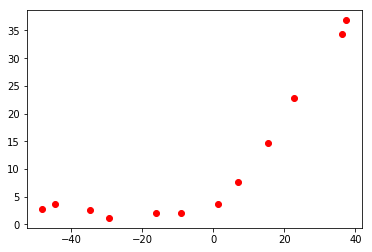

In [386]:
plt.scatter(X_train, y_train, color='red')

Now we define our hypothesis $h_{\theta}(X)$ and cost function $J(\theta)$. We're doing linear regression with $L^2$ regularization, so $h(X) = \sum_{a, b} X_{ab} \theta_b \hat{e}_a$, and the cost function is $J_{\text{MSE}}(\theta) = \frac{1}{2m}\sum_{a}(h(x_a)-y_a)^2 + \frac{\lambda}{2m}\sum_{a>0} \theta_a$.

In [339]:
def h(theta, X):
    tmp_X = np.insert(X, 0, 1, axis=1)
    return tmp_X.dot(theta)

In [340]:
def J(theta, X, y, reg):
    m = X.shape[0]
    return 1/(2*m)*(np.linalg.norm(h(theta, X) - y))**2 + reg/(2*m)*(np.linalg.norm(theta[1:])**2)

Check that we're getting the correct cost for the training data. (Should be 303.993)

In [387]:
J(np.ones(2), X_train, y_train, 1)

303.99319222026423

Now we define the gradient of the cost function $\nabla J$ and check its value. (Should be $\begin{pmatrix}-15.30\\ 598.250\end{pmatrix}$).

In [342]:
def gradJ(theta, X, y, reg):
    m = X.shape[0]
    tmp_theta = np.copy(theta)
    tmp_theta[0] = 0
    tmp_X = np.insert(X, 0, 1, axis=1)
    return 1/m*(tmp_X.transpose().dot(h(theta, X) - y)) + reg/m*tmp_theta

In [343]:
gradJ(np.ones(2), X_train, y_train, 1)

array([-15.30301567, 598.25074417])

Now we can fit the model by minimizing $J$. We initialize $\theta$ to $(1, 1)$, and set the regularization parameter $\lambda=0$ to start.

In [344]:
theta_min = scipy.optimize.fmin_cg(lambda t: J(t, X_train, y_train, 0),
                                   np.ones(2),
                                   fprime=lambda t: gradJ(t, X_train, y_train, 0),
                                  ) 

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28


We plot our fit line with the data.

In [345]:
print(theta_min)
x_plot = np.arange(-50, 40)
y_plot = theta_min[0] + theta_min[1]*x_plot

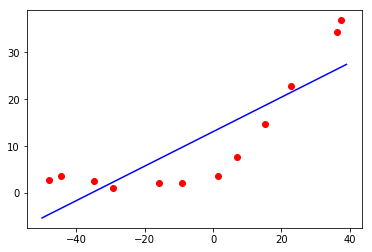

In [346]:
plt.scatter(X_train, y_train, color='red')
plt.plot(x_plot, y_plot, color='blue')

___Learning curves___

We can look at the training error when we train on different-sized subsets of the training data.

In [419]:
def plot_training_error(X, y, X_val, y_val):
    m = X.shape[0]
    training_error = []
    cv_error = []
    for i in range(1, m+1):
        theta_star = scipy.optimize.fmin_cg(lambda t: J(t, X[0:i], y[0:i], 0),
                                   np.ones(2),
                                   fprime=lambda t: gradJ(t, X[0:i], y[0:i], 0),
                                  disp = 0) 
        training_error.append(J(theta_star, X[0:i], y[0:i], 0))
        cv_error.append(J(theta_star, X_val, y_val, 0))
    x = np.arange(1, m+1)
    plt.plot(x, training_error)
    plt.plot(x, cv_error)
        

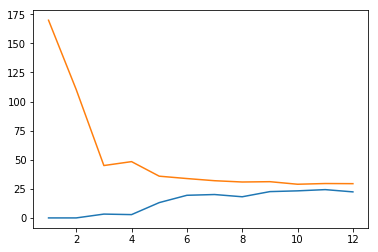

In [421]:
plot_training_error(X_train, y_train, X_cv, y_cv)

___Polynomial regression___

Now we implement polynomial feature mapping, $x \mapsto (x, x^2, \ldots, x^p)$. We'll also need to normalize the monomial features.

In [347]:
def poly_features(X, p):
    poly_X = copy.deepcopy(X)
    for i in range(2, p+1):
        poly_X = np.concatenate((poly_X, np.power(X, i)), axis=1)
    return poly_X

In [348]:
J(np.ones(4), poly_features(X_train, 3), y_train, 0)

1118460208.749629

In [349]:
def feature_normalize(X):
    subtract_mean = lambda x: x - np.mean(x)
    scale = lambda x: x/np.std(x)
    X_normalized = np.apply_along_axis(subtract_mean, 0, X)
    X_normalized = np.apply_along_axis(scale, 0, X_normalized)
    return X_normalized

In [350]:
J(np.ones(4), feature_normalize(poly_features(X_train, 3)), y_train, 0)

110.58321531946416

We transform our training data using this polynomial feature map.

In [351]:
X_poly_norm = feature_normalize(poly_features(X_train, 8))
X_poly_norm.shape

(12, 8)

We'll do regularized linear regression using this polynomial model and compare results with different amounts of regularization. ($\lambda = 0, 1, 100$).

In [367]:
theta_min_0 = scipy.optimize.fmin_cg(lambda t: J(t, X_poly_norm, y_train, 0),
                                   np.ones(9),
                                   fprime=lambda t: gradJ(t, X_poly_norm, y_train, 0),
                                  ) 
theta_min_1= scipy.optimize.fmin_cg(lambda t: J(t, X_poly_norm, y_train, 1),
                                   np.ones(9),
                                   fprime=lambda t: gradJ(t, X_poly_norm, y_train, 1),
                                  ) 
theta_min_100= scipy.optimize.fmin_cg(lambda t: J(t, X_poly_norm, y_train, 100),
                                   np.ones(9),
                                   fprime=lambda t: gradJ(t, X_poly_norm, y_train, 100),
                                  ) 

Optimization terminated successfully.
         Current function value: 0.028895
         Iterations: 1601
         Function evaluations: 3065
         Gradient evaluations: 3065
Optimization terminated successfully.
         Current function value: 6.830463
         Iterations: 26
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 65.950955
         Iterations: 9
         Function evaluations: 18
         Gradient evaluations: 18


In [378]:
x_plot0 = np.arange(-50, 40).reshape((90, 1))
x_plot0 = np.insert(feature_normalize(poly_features(x_plot0, 8)), 0, 1, axis=1)
y_plot0 = x_plot0.dot(theta_min_0)
x_plot0 = np.arange(-50, 40)
x_plot1 = np.arange(-50, 40).reshape((90, 1))
x_plot1 = np.insert(feature_normalize(poly_features(x_plot1, 8)), 0, 1, axis=1)
y_plot1 = x_plot1.dot(theta_min_1)
x_plot1 = np.arange(-50, 40)
x_plot100 = np.arange(-50, 40).reshape((90, 1))
x_plot100 = np.insert(feature_normalize(poly_features(x_plot100, 8)), 0, 1, axis=1)
y_plot100 = x_plot100.dot(theta_min_100)
x_plot100 = np.arange(-50, 40)

Text(0.5,1,'8th order polynomial fit, $\\lambda=0$')

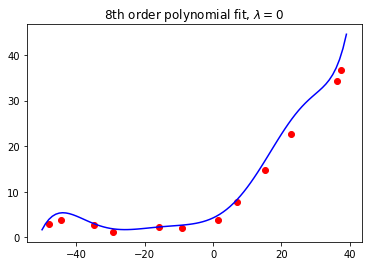

In [391]:
plt.scatter(X_train, y_train, color='red')
plt.plot(x_plot0, y_plot0, color='blue')
plt.title(r"8th order polynomial fit, $\lambda=0$")

Text(0.5,1,'8th order polynomial fit, $\\lambda=1$')

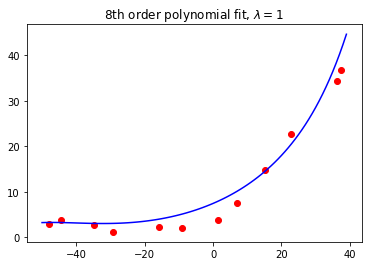

In [393]:
plt.scatter(X_train, y_train, color='red')
plt.plot(x_plot1, y_plot1, color='blue')
plt.title(r"8th order polynomial fit, $\lambda=1$")

Text(0.5,1,'8th order polynomial fit, $\\lambda=100$')

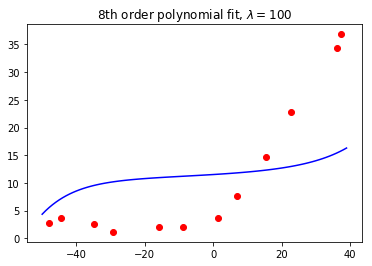

In [392]:
plt.scatter(X_train, y_train, color='red')
plt.plot(x_plot100, y_plot100, color='blue')
plt.title(r"8th order polynomial fit, $\lambda=100$")

The $\lambda=0$ model overfits, the $\lambda=100$ model underfits, but $\lambda=1$ is Goldilocks.